# Steps in Mission Processing

In [2]:
import cftime
import matplotlib.pyplot as plt
import netCDF4 as nc
import numpy as np
from PyAstronomy import pyaC
from scipy import stats
import cmocean
import random

import mission_tools

%load_ext autoreload
%autoreload 2
%matplotlib widget

In [3]:
mission_nc_path = '../microSWIFT_data/final_dataset/mission_19.nc'
mission_dataset = nc.Dataset(mission_nc_path, mode='r')
mission19_time = np.median(mission_dataset['time'][:])
mission_dataset

/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4_CLASSIC data model, file format HDF5):
    title: DUNEX microSWIFT drifter - Mission 19
    summary: University of Washington - Applied Physics Lab team collected these data using microSWIFT wave buoys at the USACE Field Research Facility as part of the USCRP funded project DUNEX (During Nearshore Events Experiment). The file contains both directly measured and computed quantities from the drifting wave buoys. The collection and processing of these data is explained in the github repository at https://github.com/SASlabgroup/DUNEXMainExp along with examples of how these data can be used.
    institution: University of Washington - Applied Physics Lab
    source: Observations from microSWIFT drifters deployed in the DUring Nearshore Events eXperiment (DUNEX)
    Conventions: CF-1.6
    Metadata_Conventions: Unidata Dataset Discovery v1.0
    creator_country: USA
    creator_email: erainvil@uw.edu
    creator_name: EJ Rainville, Jim T

In [4]:
# Add in breaking location start based on gamma value for area and average shoreline location
# Based on Raubenheimer 1996 the average gamma value at Duck is approximately .35
gamma = 0.35
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_8m-array_202110.nc'
mission19_hs = mission_tools.closest_awac_sig_wave_height(mission19_time, awac_file)
print(mission19_hs)

# Compute depth that waves should be breaking in 
mission19_break_depth = mission19_hs / gamma
print(mission19_break_depth)

# Cross Shore Location for start of Breaking
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
bathy_dataset = nc.Dataset(bathy_file)

# Create grid from coordinates
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

mission19_xs_gamma_location = np.interp(-mission19_break_depth, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
print(mission19_xs_gamma_location)

# Get shoreline location from waterlevel data
waterlevel_file = '../microSWIFT_data/FRFdata/FRF-ocean_waterlevel_eopNoaaTide_202110.nc'
waterlevel_dataset = nc.Dataset(waterlevel_file)
waterlevel = waterlevel_dataset['waterLevel'][:]
waterlevel_time = waterlevel_dataset['time'][:]
mission19_waterlevel = np.interp(mission19_time, waterlevel_time, waterlevel)
print(mission19_waterlevel)

mission19_shoreline_location = np.interp(mission19_waterlevel, np.flip(np.nanmean(bathy, axis=0)), np.flip(bathy_dataset['xFRF'][:]))
print(mission19_shoreline_location)

1.1538847635243603
3.2968136100696013
273.3005642795343
-0.3963334080643127
125.69255563551208


In [5]:
# Define a colormap so each microSWIFT gets a different color
def get_cmap(n, name='tab20'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

/var/folders/v_/wf8btpmn6s588vb9xbxbr9bw0000gp/T/ipykernel_48221/321570780.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  return plt.cm.get_cmap(name, n)


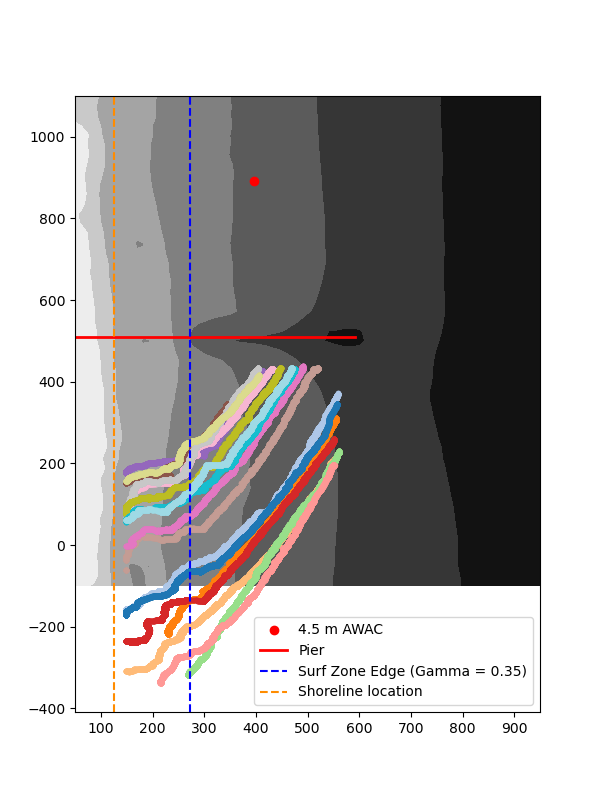

In [6]:
bathy_dataset = nc.Dataset(bathy_file)
xFRF_grid, yFRF_grid = np.meshgrid(bathy_dataset['xFRF'][:],
                                    bathy_dataset['yFRF'][:])
bathy = bathy_dataset['elevation'][0,:,:]

fig, ax = plt.subplots(figsize=(6,8))

ax.contourf(xFRF_grid, yFRF_grid, bathy, cmap='gray')
bathy_dataset.close()

awac4p5m_location = [397.35, 890.98] # Converted from lat lon locations 
                                        # published on FRF data portal
ax.scatter(awac4p5m_location[0],awac4p5m_location[1],
            color='r', label='4.5 m AWAC')

ax.plot([50,591],[510,510], linewidth=2, color='r', label='Pier')

cmap = get_cmap(mission_dataset['trajectory'][:].size)
colors = [cmap(n) for n in range(mission_dataset['trajectory'][:].size)]
for n in range(1, mission_dataset['trajectory'][:].size):
    im = ax.scatter(mission_dataset['xFRF'][n,:], mission_dataset['yFRF'][n,:],
                    marker='.', alpha=1, color=colors[n])

ax.scatter(mission_dataset['xFRF'][0,:], mission_dataset['yFRF'][0,:],
                    marker='.', alpha=1, color=colors[0])

ax.axvline(mission19_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax.axvline(mission19_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')

ax.legend()

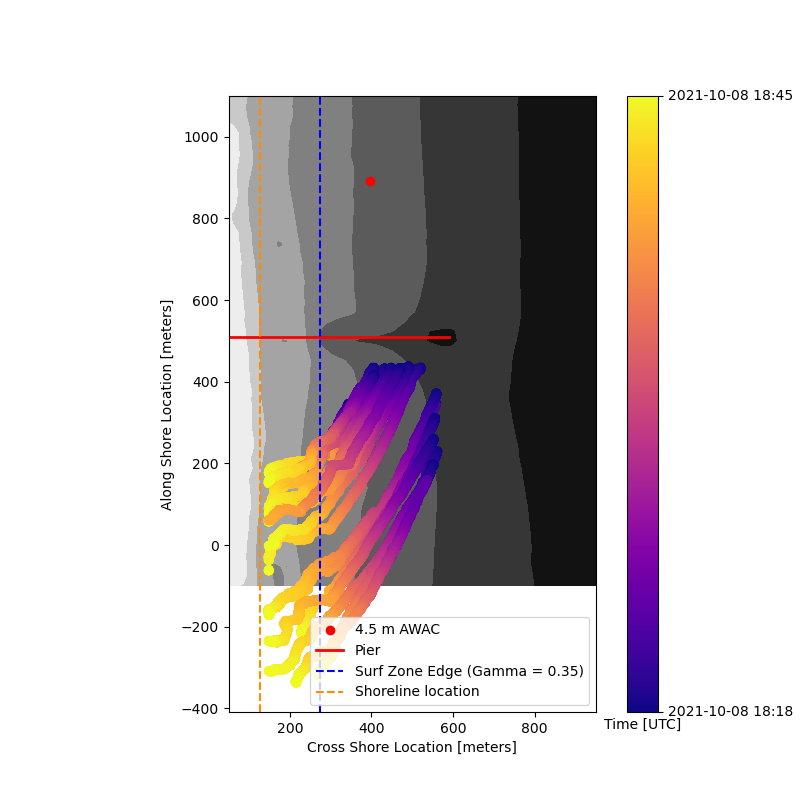

In [7]:
bathy_file = '../microSWIFT_data/FRFdata/FRF_geomorphology_DEMs_surveyDEM_20211021.nc'
ax = mission_tools.plot_mission_tracks(mission_dataset, bathy_file)
ax.axvline(mission19_xs_gamma_location, label='Surf Zone Edge (Gamma = 0.35)', color='b', linestyle='dashed')
ax.axvline(mission19_shoreline_location, label='Shoreline location', color='darkorange', linestyle='dashed')
ax.legend(loc='lower right')

Text(0, 0.5, 'Sea Surface Elevation [m]')

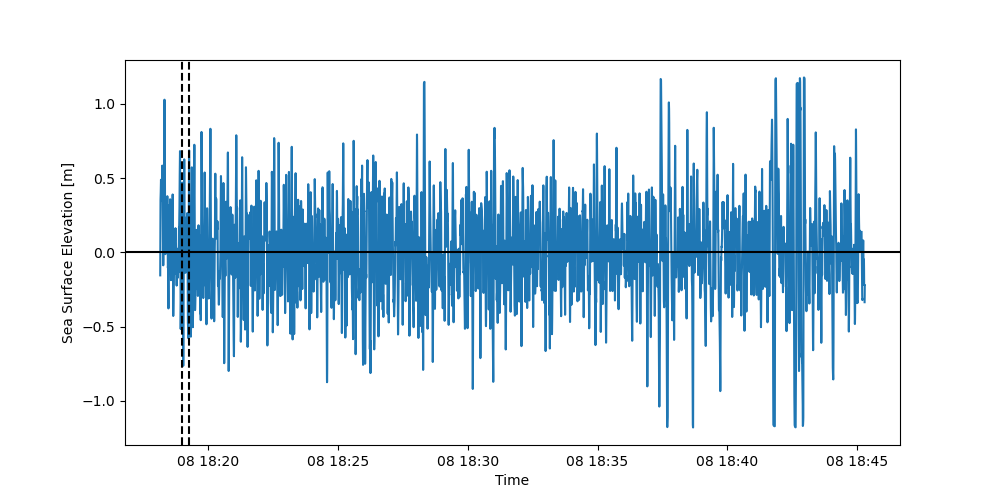

In [8]:
slice_start = 700
slice_end = 900

fig, ax = plt.subplots(figsize=(10,5))
time = cftime.num2pydate(mission_dataset['time'],
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
# for n in range(1, mission_dataset['trajectory'][:].size):
#     ax.plot(time,
#             mission_dataset['sea_surface_elevation'][n,:], 
#             color=colors[n], alpha=0.1)
ax.plot(time, mission_dataset['sea_surface_elevation'][0,:], color=colors[0])
ax.axhline(y=0, color='k')
ax.axvline(x=time[slice_start], color='k', linestyle='dashed')
ax.axvline(x=time[slice_end], color='k', linestyle='dashed')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m]')

Text(0, 0.5, 'Sea Surface Elevation [m]')

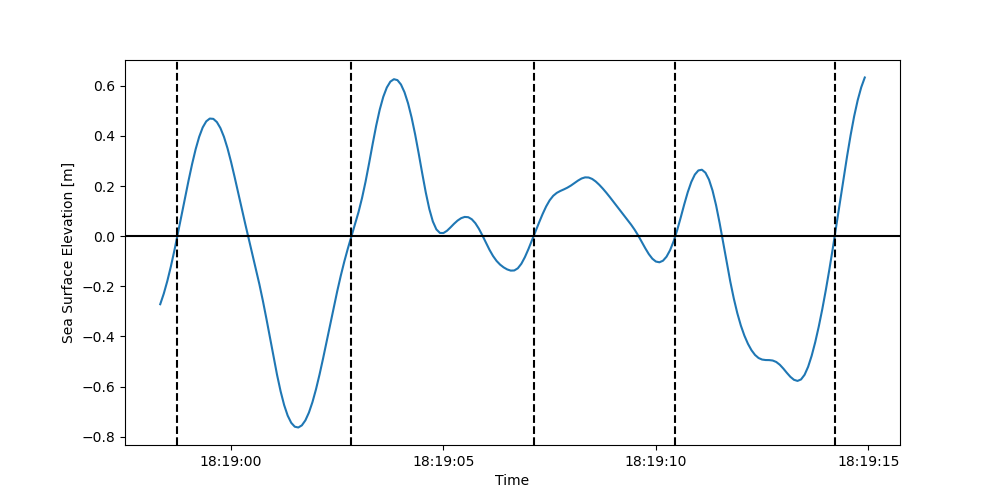

In [9]:
fig, ax = plt.subplots(figsize=(10,5))

# for n in range(1, mission_dataset['trajectory'][:].size):
#     ax.plot(time[slice_start:slice_end],
#             mission_dataset['sea_surface_elevation'][n,slice_start:slice_end], 
#             color=colors[n], alpha=0.1)

eta_example = mission_dataset['sea_surface_elevation'][0,slice_start:slice_end]
time_example = time[slice_start:slice_end]

ax.plot(time_example, eta_example, color=colors[0], alpha=1)

cross_time, \
cross_ind = pyaC.zerocross1d(mission_dataset['time'][slice_start:slice_end],
                                          eta_example, getIndices=True)
wave_times = cross_time[::2]
wave_datetimes = cftime.num2pydate(wave_times,
                            units=mission_dataset['time'].units,
                            calendar=mission_dataset['time'].calendar)
for n in range(len(wave_datetimes)):
    ax.axvline(wave_datetimes[n], color='k', linestyle='dashed')

ax.axhline(y=0, color='k')
ax.set_xlabel('Time')
ax.set_ylabel('Sea Surface Elevation [m]')

## Compute individual waves for each microSWIFT

In [10]:
wave_heights_each_micro = []
wave_x_locs_each_micro = []
wave_y_locs_each_micro = []
for n in range(mission_dataset['trajectory'][:].size):
    x_locations = mission_dataset['xFRF'][n,:]
    y_locations = mission_dataset['yFRF'][n,:]
    eta = mission_dataset['sea_surface_elevation'][n,:]
    time = mission_dataset['time'][:]

    wave_heights, \
    wave_x_locs, \
    wave_y_locs = mission_tools.compute_individual_waves(x_locations,
                                                        y_locations,
                                                        eta, time,
                                                        bathy_file,
                                                        single_trajectory=True)
    wave_heights_each_micro.append(wave_heights)
    wave_x_locs_each_micro.append(wave_x_locs)
    wave_y_locs_each_micro.append(wave_y_locs)

In [15]:
wave_heights_flattened = np.concatenate(wave_heights_each_micro).flatten()
wave_x_locs = np.concatenate(wave_x_locs_each_micro).flatten()
outside_surfzone_inds = np.where(wave_x_locs > mission19_xs_gamma_location)
wave_heights_outside_surf = wave_heights_flattened[outside_surfzone_inds[0]]

## Plot a stacked histogram of the wave height from each micro

Number of Waves: 4708


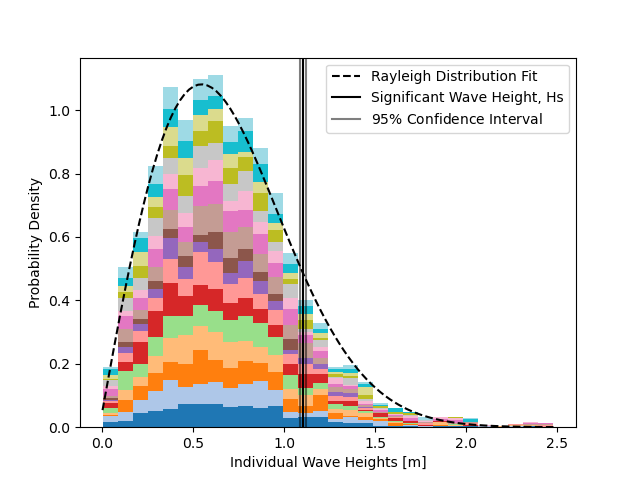

In [ ]:
fig, ax = plt.subplots()
ax.hist(wave_heights_each_micro, bins=30,
                  stacked=True, density=True, color=colors)
wave_heights_flat = np.concatenate(wave_heights_each_micro).flatten()
loc, scale = stats.rayleigh.fit(wave_heights_flat)
rayleigh_dist_x = np.linspace(min(wave_heights_flat),
                              max(wave_heights_flat),
                              100)
ax.plot(rayleigh_dist_x,
            stats.rayleigh(scale=scale, loc=loc).pdf(rayleigh_dist_x),
            label="Rayleigh Distribution Fit", color='k',
            linestyle='dashed')

sig_wave_height = mission_tools.compute_rms_wave_height(wave_heights_flat) * 1.416
wave_heights = (wave_heights_flat,) # data must be in a sequence for the bootstrap function
bootstrap_ci = stats.bootstrap(wave_heights, mission_tools.compute_rms_wave_height, confidence_level=0.95, method='percentile')
ci_low = bootstrap_ci.confidence_interval[0] * 1.416
ci_high = bootstrap_ci.confidence_interval[1] * 1.416
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
mission_time = np.median(mission_dataset['time'][:])
awac_sig_wave_height = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)


ax.axvline(x=sig_wave_height, label='Significant Wave Height, Hs', color='k')
ax.axvline(x=ci_low, color='k', alpha=0.5)
ax.axvline(x=ci_high, color='k', alpha=0.5, label='$95 \%$ Confidence Interval')
ax.set_xlabel('Individual Wave Heights [m]')
ax.set_ylabel('Probability Density')
ax.legend()

print('Number of Waves: {}'.format(wave_heights_flat.size))

Number of Waves: 3859


/opt/homebrew/Caskroom/mambaforge/base/envs/dunex-venv/lib/python3.11/site-packages/numpy/core/fromnumeric.py:784: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


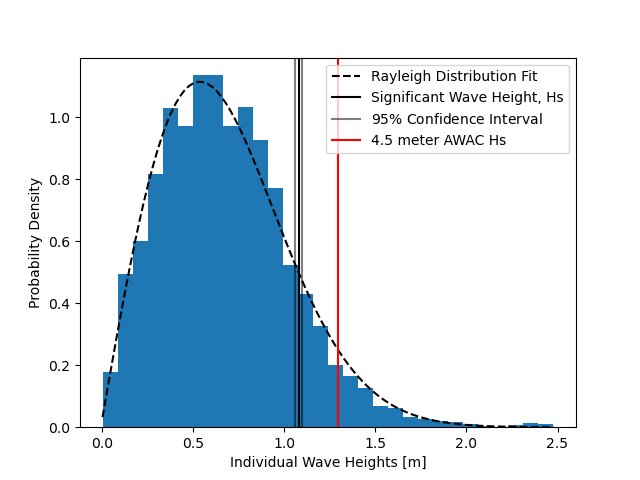

In [18]:
fig, ax = plt.subplots()
ax.hist(wave_heights_outside_surf, bins=30,
                  stacked=True, density=True)
loc, scale = stats.rayleigh.fit(wave_heights_outside_surf)
rayleigh_dist_x = np.linspace(min(wave_heights_outside_surf),
                              max(wave_heights_outside_surf),
                              100)
ax.plot(rayleigh_dist_x,
            stats.rayleigh(scale=scale, loc=loc).pdf(rayleigh_dist_x),
            label="Rayleigh Distribution Fit", color='k',
            linestyle='dashed')

sig_wave_height = mission_tools.compute_rms_wave_height(wave_heights_outside_surf) * 1.416
wave_heights = (wave_heights_outside_surf,) # data must be in a sequence for the bootstrap function
bootstrap_ci = stats.bootstrap(wave_heights, mission_tools.compute_rms_wave_height, confidence_level=0.95, method='percentile')
ci_low = bootstrap_ci.confidence_interval[0] * 1.416
ci_high = bootstrap_ci.confidence_interval[1] * 1.416
awac_file = '../microSWIFT_data/FRFdata/FRF-ocean_waves_awac-4.5m_202110.nc'
mission_time = np.median(mission_dataset['time'][:])
awac_sig_wave_height = mission_tools.closest_awac_sig_wave_height(mission_time, awac_file)


ax.axvline(x=sig_wave_height, label='Significant Wave Height, Hs', color='k')
ax.axvline(x=ci_low, color='k', alpha=0.5)
ax.axvline(x=ci_high, color='k', alpha=0.5, label='$95 \%$ Confidence Interval')
ax.axvline(awac_sig_wave_height, color='r', label='4.5 meter AWAC Hs')
ax.set_xlabel('Individual Wave Heights [m]')
ax.set_ylabel('Probability Density')
ax.legend()

print('Number of Waves: {}'.format(wave_heights_outside_surf.size))